energy_type
electricity    4375
gas            4039
Name: count, dtype: int64


,energy_type,TotalkWh_mean,TotalkWh_median,TotalkWh_min,TotalkWh_max,TotalTherms_mean,TotalTherms_median,TotalTherms_min,TotalTherms_max
0,electricity,2721159.01,1591066.0,3885.0,16151489.0,0.00,0.0,0.0,0.0
1,gas,0.00,0.0,0.0,0.0,278818.54,241697.0,1247.0,1208569.0


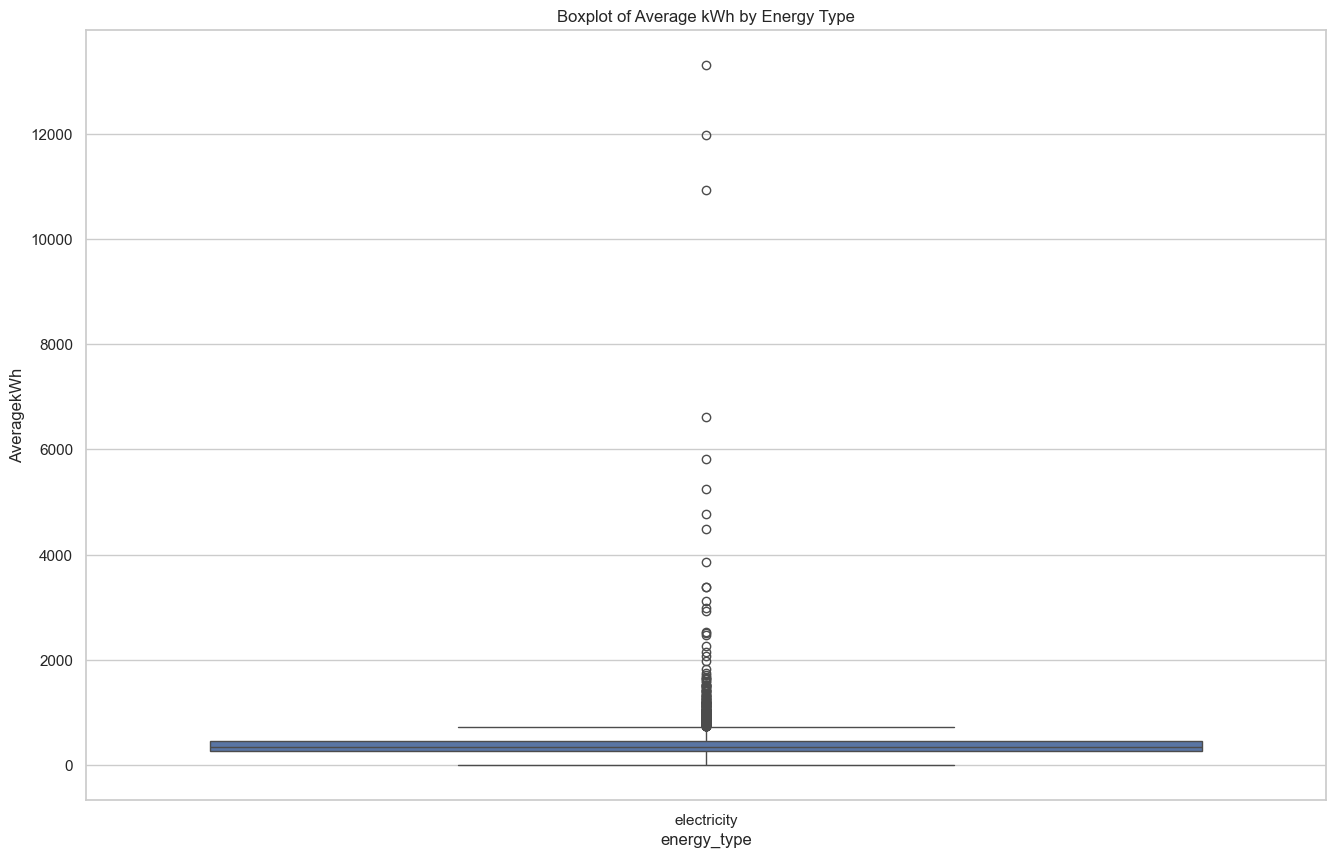

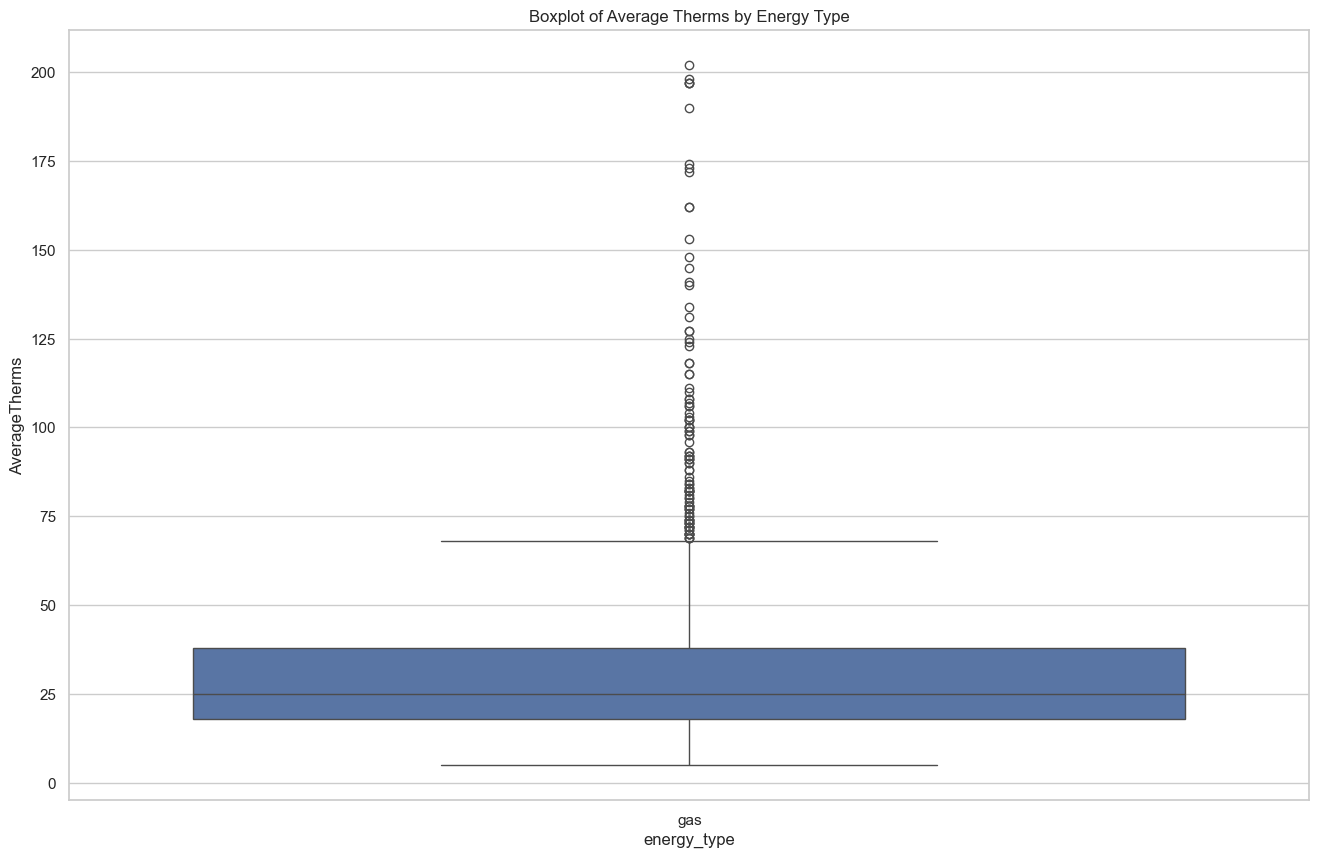

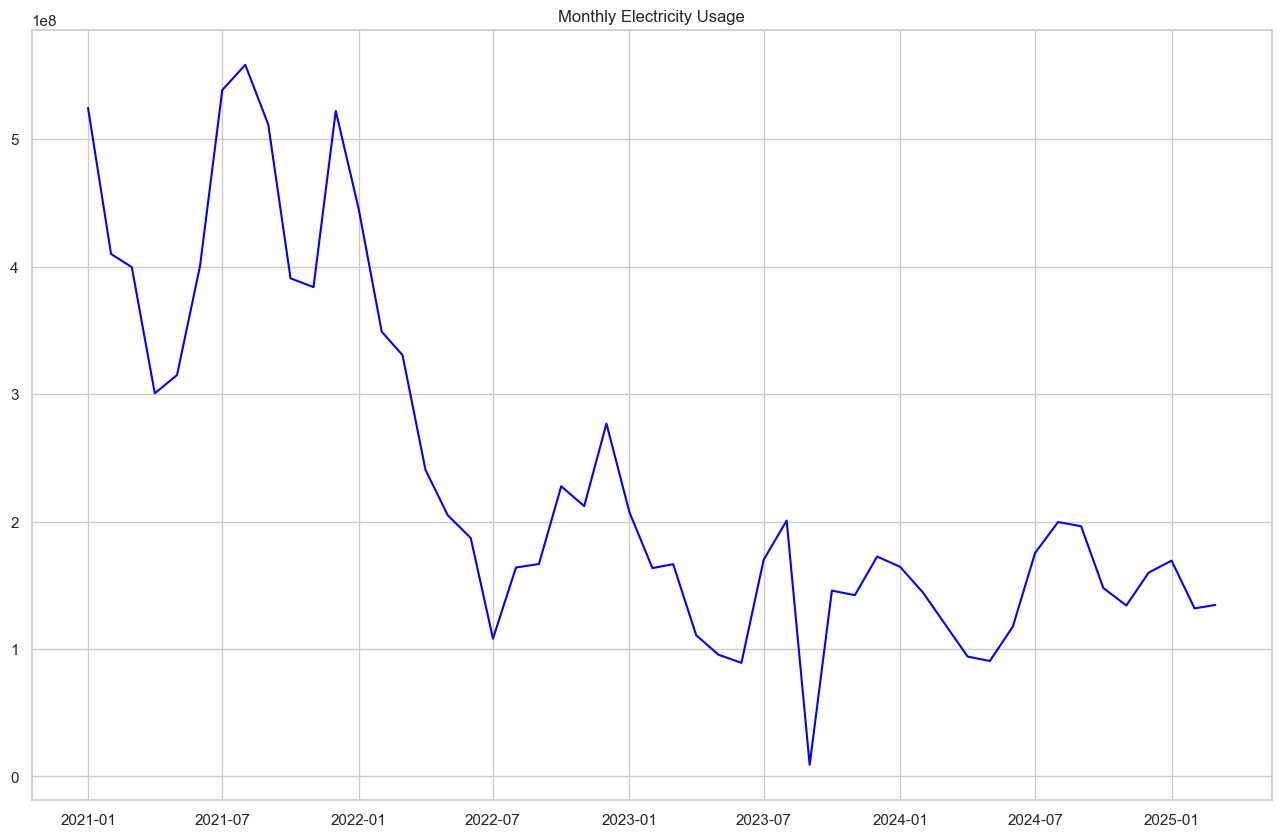

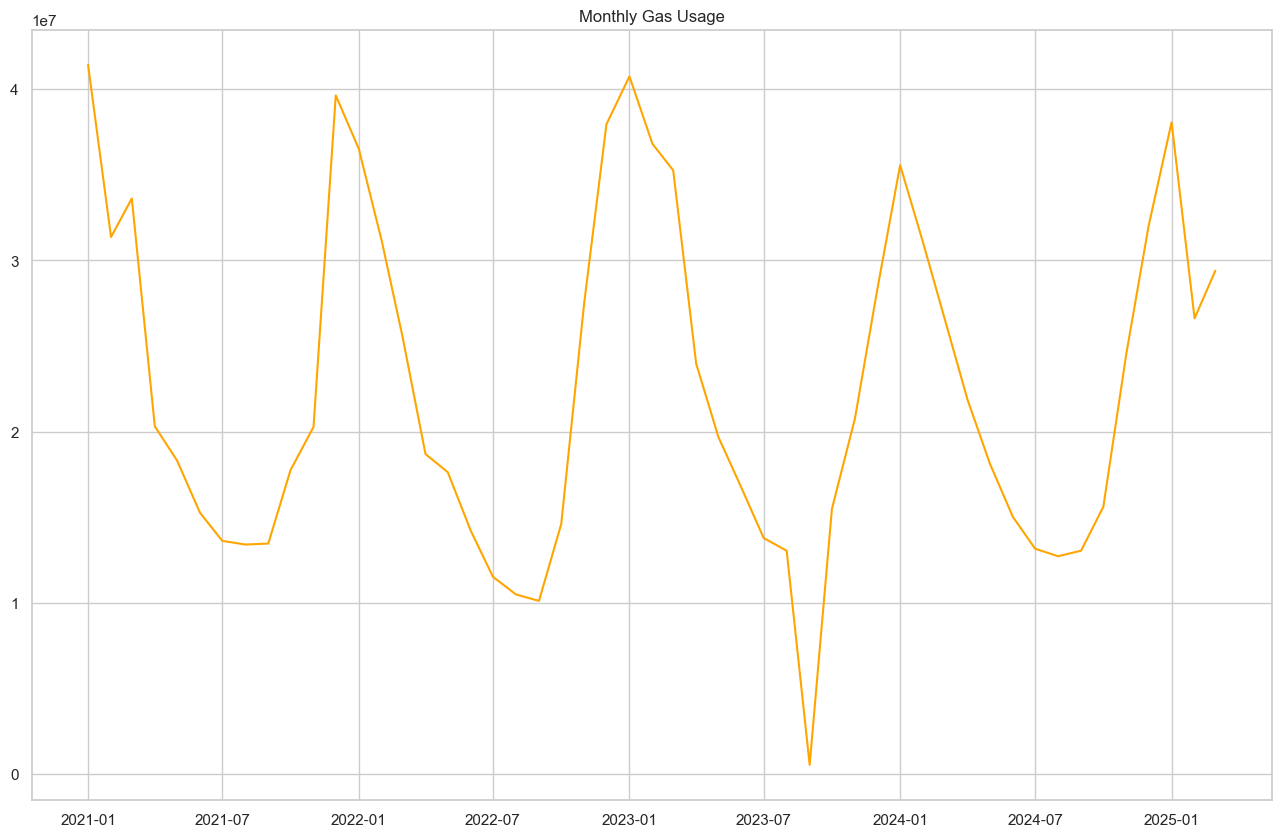

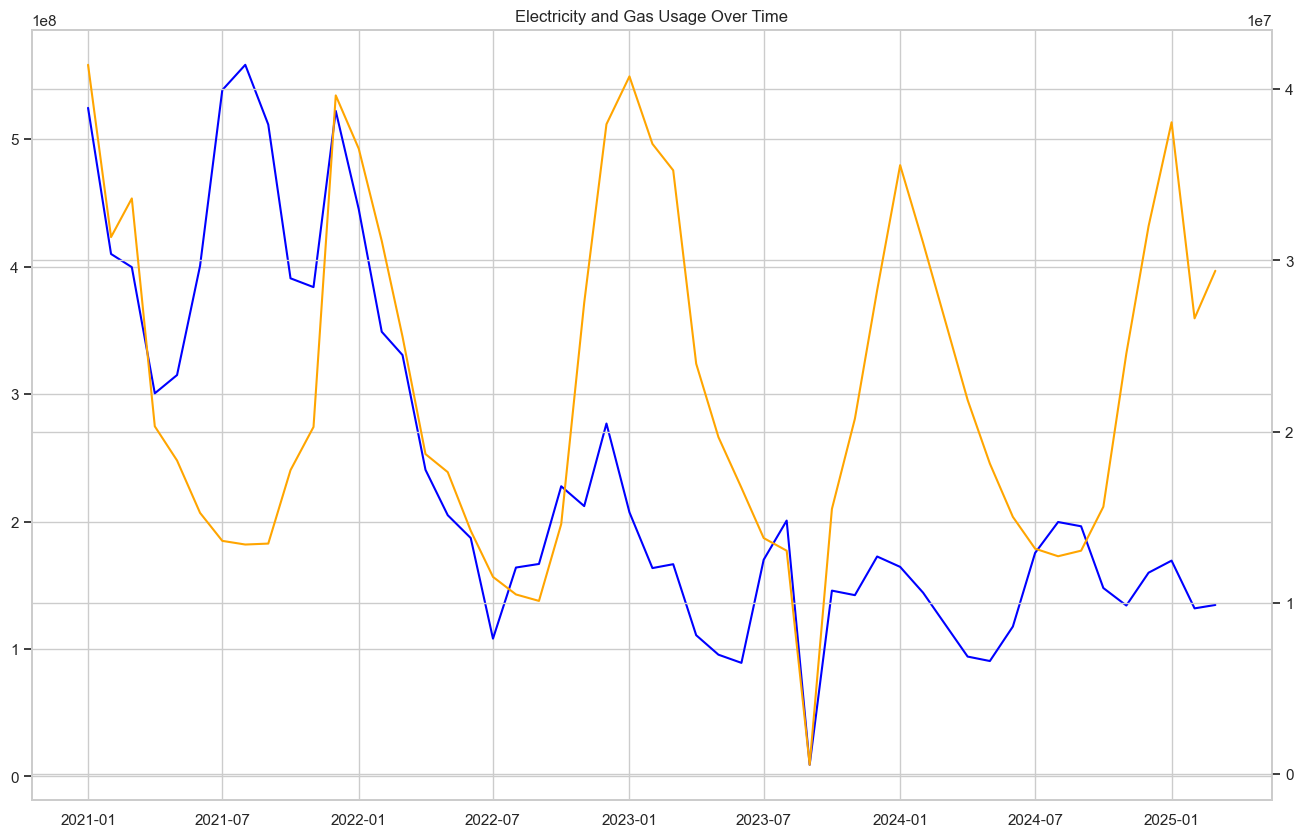

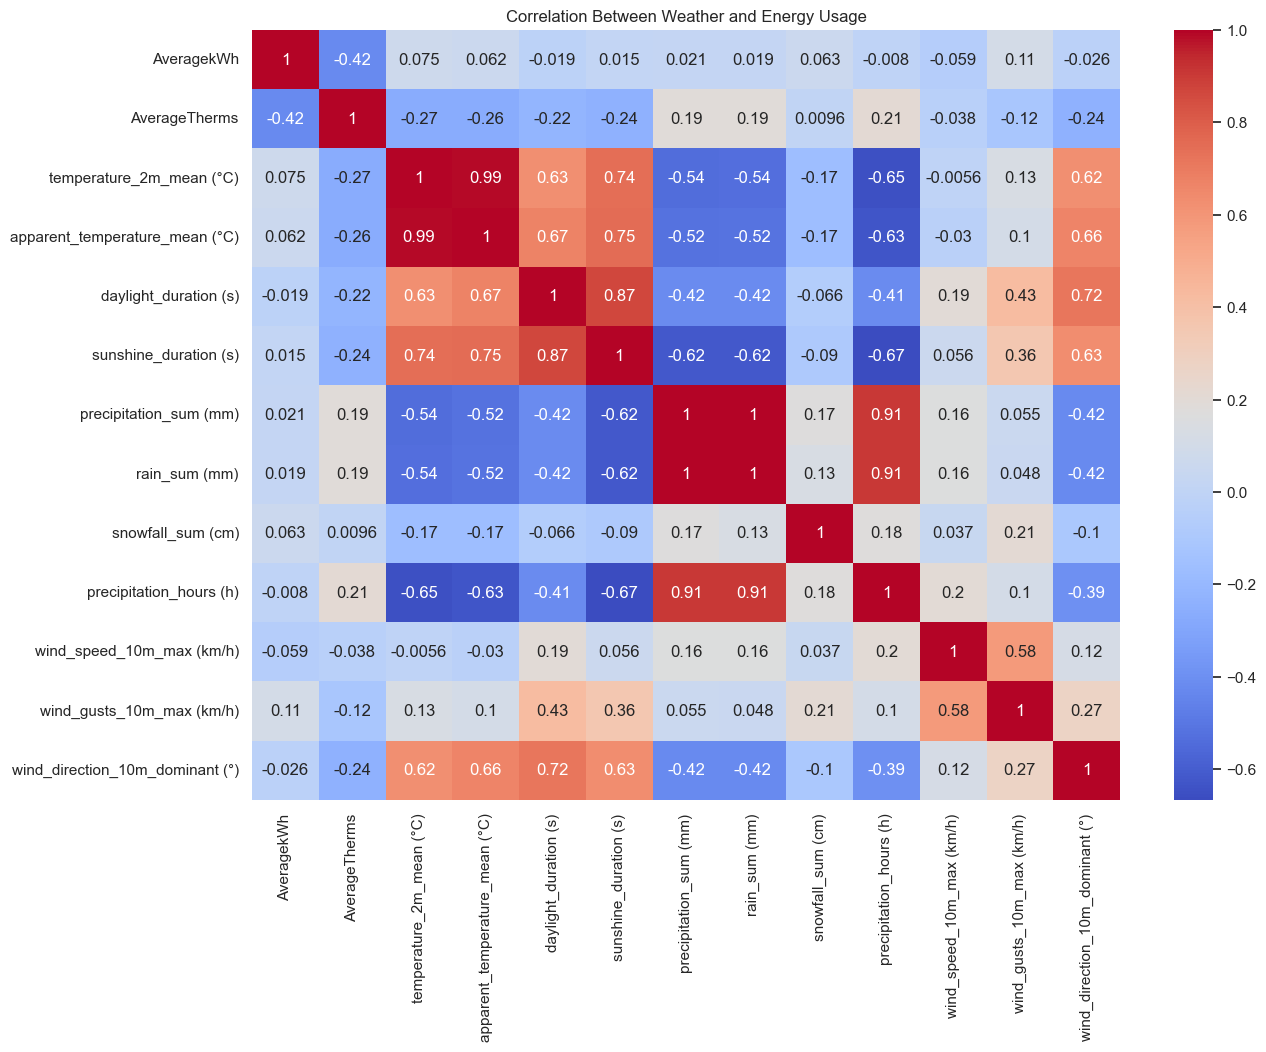

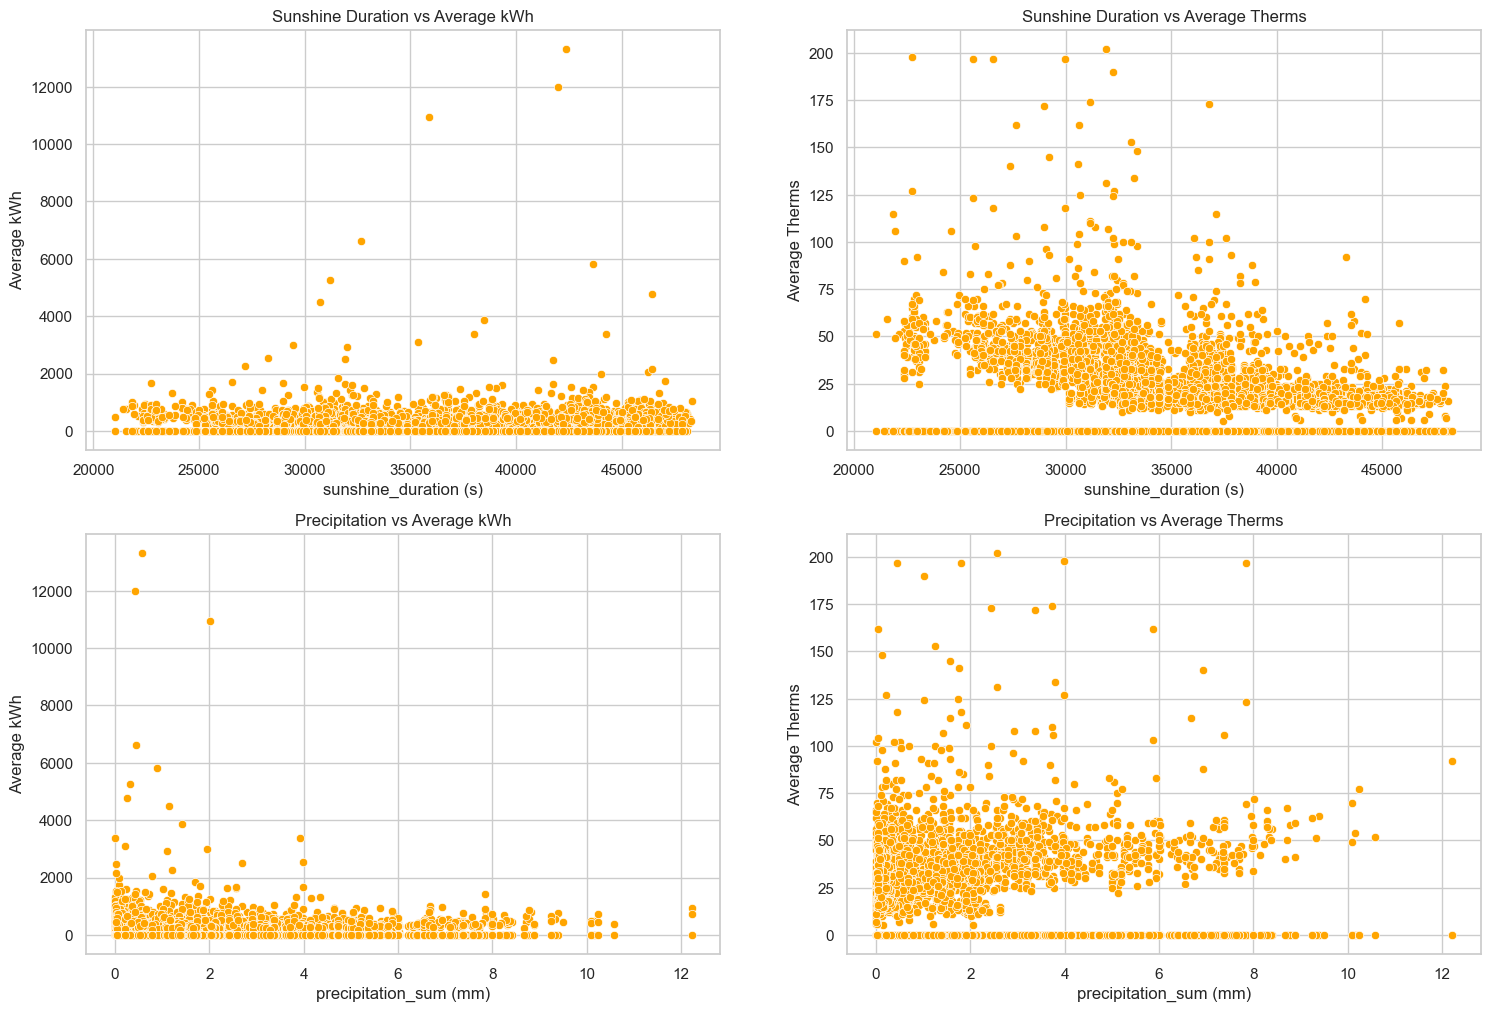

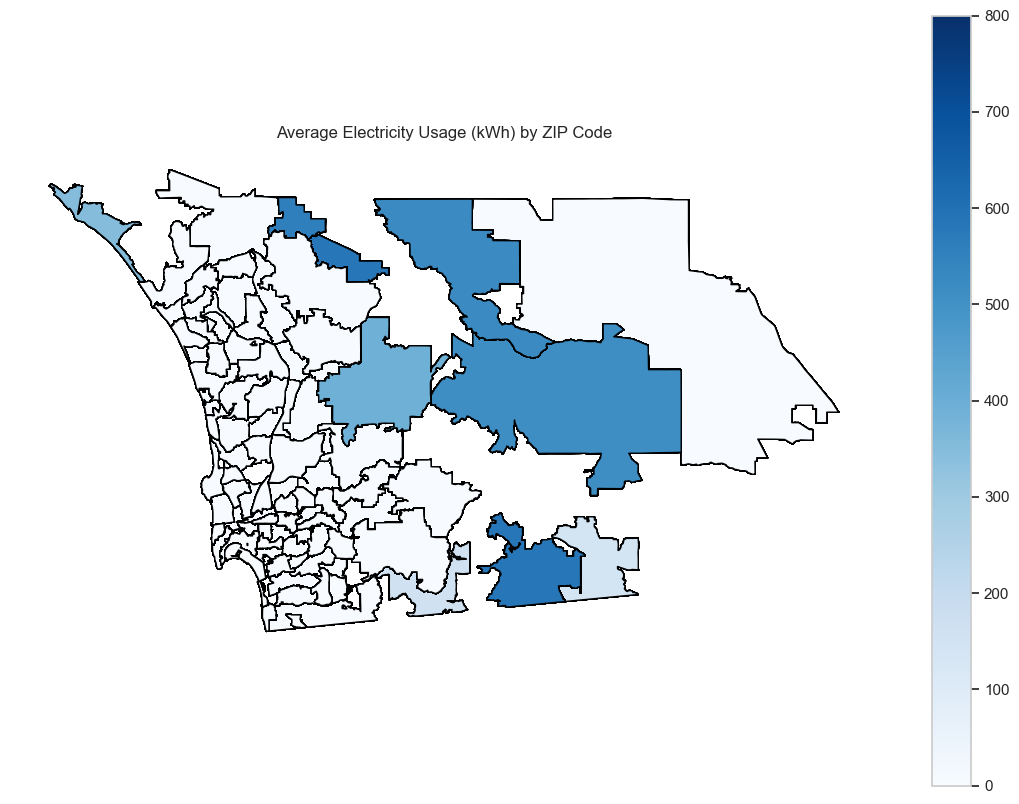

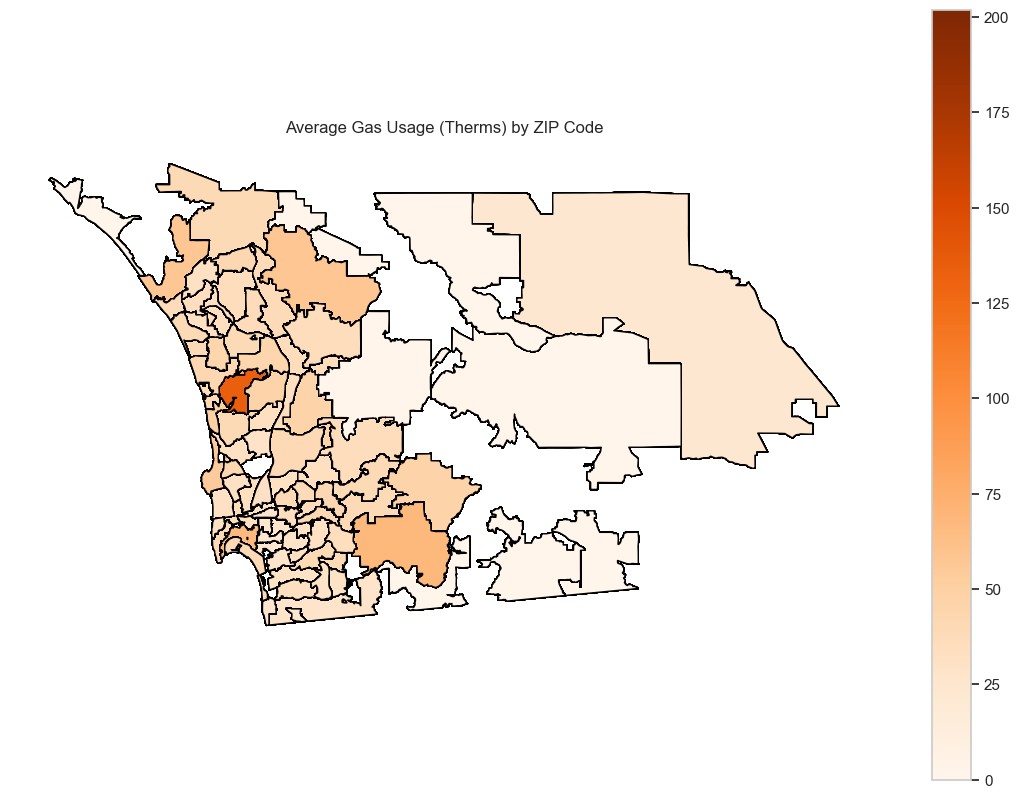

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

sns.set_theme(style="whitegrid")

df = pd.read_csv("./datasets/merged_energy_weather_data.csv")
df = df[(df['TotalkWh'] >= 0) & (df['TotalTherms'] >= 0)]

print(df['energy_type'].value_counts())
summary_stats = df.groupby('energy_type').agg({'TotalkWh': ['mean', 'median', 'min', 'max'],'TotalTherms': ['mean', 'median', 'min', 'max']}).round(2)
summary_stats.columns = ['_'.join(col) for col in summary_stats.columns]
summary_stats.reset_index(inplace=True)
summary_stats.to_csv("summary_stats.csv", index=False)
data = pd.read_csv("summary_stats.csv")
display(data.head())


plt.figure(figsize=(16, 10))
sns.boxplot(x='energy_type', y='AveragekWh', data=df[df['AveragekWh'] > 0])
plt.title('Boxplot of Average kWh by Energy Type')
plt.show()

plt.figure(figsize=(16, 10))
sns.boxplot(x='energy_type', y='AverageTherms', data=df[df['AverageTherms'] > 0])
plt.title('Boxplot of Average Therms by Energy Type')
plt.show()

df['Date'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=1))
monthly_usage = df.groupby(['Date', 'energy_type']).agg({'TotalkWh': 'sum','TotalTherms': 'sum'}).reset_index()

plt.figure(figsize=(16, 10))
subset_electricity = monthly_usage[monthly_usage['energy_type'] == 'electricity']
plt.plot(subset_electricity['Date'], subset_electricity['TotalkWh'], color='blue')
plt.title('Monthly Electricity Usage')
plt.show()

plt.figure(figsize=(16, 10))
subset_gas = monthly_usage[monthly_usage['energy_type'] == 'gas']
plt.plot(subset_gas['Date'], subset_gas['TotalTherms'], color='orange')
plt.title('Monthly Gas Usage')
plt.show()

plt.figure(figsize=(16, 10))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(subset_electricity['Date'], subset_electricity['TotalkWh'], color='blue')
ax2.plot(subset_gas['Date'], subset_gas['TotalTherms'], color='orange')
plt.title('Electricity and Gas Usage Over Time')
plt.show()

weather_features = ['temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_duration (s)','sunshine_duration (s)', 'precipitation_sum (mm)', 'rain_sum (mm)','snowfall_sum (cm)', 'precipitation_hours (h)', 'wind_speed_10m_max (km/h)','wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)']

corr_df = df[['AveragekWh', 'AverageTherms'] + weather_features].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Between Weather and Energy Usage')
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

sns.scatterplot(x='sunshine_duration (s)', y='AveragekWh', data=df, ax=axs[0, 0], color='orange')
axs[0, 0].set_title('Sunshine Duration vs Average kWh')
axs[0, 0].set_xlabel('sunshine_duration (s)')
axs[0, 0].set_ylabel('Average kWh')

sns.scatterplot(x='sunshine_duration (s)', y='AverageTherms', data=df, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Sunshine Duration vs Average Therms')
axs[0, 1].set_xlabel('sunshine_duration (s)')
axs[0, 1].set_ylabel('Average Therms')

sns.scatterplot(x='precipitation_sum (mm)', y='AveragekWh', data=df, ax=axs[1, 0], color='orange')
axs[1, 0].set_title('Precipitation vs Average kWh')
axs[1, 0].set_xlabel('precipitation_sum (mm)')
axs[1, 0].set_ylabel('Average kWh')

sns.scatterplot(x='precipitation_sum (mm)', y='AverageTherms', data=df, ax=axs[1, 1], color='orange')
axs[1, 1].set_title('Precipitation vs Average Therms')
axs[1, 1].set_xlabel('precipitation_sum (mm)')
axs[1, 1].set_ylabel('Average Therms')
plt.show()

zip_shapes = gpd.read_file("./zip_shape/tl_2023_us_zcta520.shp")
zip_shapes['ZCTA5CE20'] = zip_shapes['ZCTA5CE20'].astype(int)

geo_df = pd.merge(zip_shapes, df, left_on='ZCTA5CE20', right_on='ZipCode', how='inner')
geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry')
geo_df = geo_df.set_crs("EPSG:4269")
geo_df = geo_df[geo_df['ZipCode'].astype(str).str.startswith('9')]

geo_df.plot(column='AveragekWh', cmap='Blues', legend=True, edgecolor='black',vmin = 0, vmax  = 800, figsize=(14, 10))
plt.title("Average Electricity Usage (kWh) by ZIP Code")
plt.axis('off')
plt.show()

geo_df.plot(column='AverageTherms', cmap='Oranges', legend=True, edgecolor='black', figsize=(14, 10))
plt.title("Average Gas Usage (Therms) by ZIP Code")
plt.axis('off')
plt.show()

In [ ]:
# 1. What are the average, median, and range of energy use?

# Electricity (kWh):
# - Average use: 2.7 million kWh
# - Median : 1.6 million kWh
# - Range: from 3,885 to 16 million kWh

# Gas (Therms):
# - Average use: 278,819 Therms
# - Median : 241,697 Therms
# - Range: from 1,247 to 1.2 million Therms

# 2. How does energy use change over time, with weather, and across places?

# By Month:
# - Gas use goes up in colder months, probably due to heating.
# - Electricity use changes with the seasons, probably cooling in summer.

# By Weather:
# - Gas use drops when it's warmer and sunnier.
# - Electricity use doesn’t change much with weather, but rises a bit with more sunlight.

# By ZIP Code:
# - Energy use is different depending on where people live. In the way that some areas use more gas or electricity than others.

# 3.Should Gas and Electricity Be Predicted Separately?
# - Yes they should. This is because they are used differently, one for cooling, one for heating.
# - They react to weather in opposite ways.
# - They follow different seasonal trends.

# 4.Do They Need Different Features?
#  Yes, they do.
#  For electricity:
# - Sunlight, temperature, wind, and season might matter.
#  For gas:
# - Cold temperatures and time of year, such as winter, are more important.
